### Objetivos del notebook
---
En el presente notebook vamos a aprender a utilizar el algoritmo de XGBoost para trabajar con Series Temporales.

[XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

A pesar de tener sus carencias para problemas de Series Temporales (por ejemplo: no es capaz de extrapolar una tendencia), el algoritmo es muy versátil y todo Data Scientist debe conocerlo. 

El dataset con el que vamos a trabajar en este notebook contiene alrededor de **300 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. Por tanto vamos a trabajar con **Series Temporales Multivariante**.

Cada una de estas **Series Temporales** representan las ventas <u>**DIARIAS**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

Es decir, partimos de ventas diarias y vamos a tener que <u>**agrupar nuestras ventas por mes**</u> antes de crear variables o entrenar el modelo.

Al final del notebook, el alumno debe estar familiarizado con:

1. **La importancia de establecer un benchmark (CORE IDEA)** cuando empezamos a trabajar en un problema de Machine Learning. <br>
2. Realizar el **análisis exploratorio de datos (EDA)** para conocer el dataset. <br>
3. Saber utilizar **pandas de forma eficiente para manipular el dataset (resample de pandas, groupby etc).** <br>
4. **Combinar la información de diferentes Series Temporales para generar variables (ventas totales de un artículo, ventas totales de todos los artículos en una tienda) con las que alimentar nuestro modelo XGBoost (CORE IDEA).**<br>
5. **Saber identificar las variables autoexplicativas (COREA IDEA)** y sus principales causas.<br>
6. Comprender **la importancia de iterar rápido (realizar muchos experimentos) (CORE IDEA)** para testear diferentes hipótesis y variables que se construyen.
7. Aprender a hacer el **submit a Kaggle.**

---

El presente notebook contiene muchas funcionalidades avanzadas que puede requerir varias lecturas para su comprensión.
Pensamos que las secciones marcadas con **CORE IDEA** son las que mayor beneficio le reportarán al alumno. Por este motivo, le animamos a que dedique especial atención a estas ideas.

Al final del notebook, hay un sección de referencias y lecturas recomendables para que el alumno pueda seguir profundizando en estos conceptos.

---

### Índice
<a id='index'></a>

[Imports del notebook](#imports_notebook)<br>
[Helpers Time Series](#helpers)<br>
[Data Loading](#data_load)<br>
[La idea del Benchmark (**CORE IDEA**)](#benchmark)<br>
[Agrupación de las ventas por mes (**CORE IDEA**)](#monthly_agg)<br>
[Data Imputation](#impute)<br>
[EDA](#eda)<br>
[--> 1. EDA: Global Sales](#eda_global_sales)<br>
[--> 2. EDA: Top 3 Cities](#eda_top_3_cities)<br>
[--> 3. EDA: Top 3 Categories](#eda_top_3_categories)<br>
[Build Time Series Features (**CORE IDEA**)](#build_ts_features)<br>
[Join TS Features](#join_ts_features)<br>
[Train Test Split](#train_test_split)<br>
[Model Train](#model_train)<br>
[Model Evaluation (**COREA IDEA**)](#model_evaluation)<br>
[Prediction](#prediction)<br>

### Conclusión
[Conclusión](#conclusion)<br>

### Referencias
[Referencias y lecturas recomendables](#referencias)<br>

<a id='imports_notebook'></a>
### Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [1]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

import xgboost as xgb

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

Numpy version 1.21.6
Pandas version 1.3.5
XGBoost version 1.6.2


In [3]:
# GLOBAL_VARIABLES
DATA_PATH = "/kaggle/input/nuclio14-dsc-0922"

TRAIN_CSV_PATH = os.path.join(DATA_PATH, "sales_train_merged.csv")

ORDER_COLUMNS = [
    'DATE',
    'UNIQUE_ID',
    'CITY_NAME',
    'CITY_ID',
    'SHOP_NAME',
    'SHOP_ID',
    'ITEM_CATEGORY_NAME',
    'ITEM_CATEGORY_ID',
    'ITEM_NAME',
    'ITEM_ID',
    'ITEM_PRICE',
    'SALES'
]

<a id='helpers'></a>
### Helpers Time Series
[Volver al índice](#index)

En este apartado definimos varias funciones auxiliares que utilizaremos a lo largo del notebook.

In [4]:
def load_data(path_data_file):
    '''
    Loads the csv file for training.
    '''
    df = pd.read_csv(path_data_file, index_col = 0)
    
    df = preprocess_df(df)
    
    return df

In [5]:
def preprocess_df(df):
    '''
    Preprocess df: upper columns, str date to datetime etc.
    '''
    df.columns = map(str.upper, df.columns)
    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d")
    
    df["CITY_ID"] = OrdinalEncoder().fit_transform(df[["CITY"]])
    
    df.rename(columns = {"CITY":"CITY_NAME", "ITEM_CNT_DAY":"SALES"}, inplace = True)
    df = df[ORDER_COLUMNS]
    
    return df

<a id='data_load'></a>
### Data Loading
[Volver al índice](#index)

Vamos a cargar nuestro dataset para comÇenzar con el EDA.

In [6]:
df = load_data(path_data_file = TRAIN_CSV_PATH)
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
31046,2014-02-01,6-5822,Voronezh,22.0,"Voronezh (Plekhanovskaya, 13)",6,Las tarjetas de pago - PSN,35,PlayStation Tienda Reposición de la billetera:...,5822,1049.00,1.0
64440,2015-01-30,12-11373,Tienda Online,16.0,La tienda en línea Emergencias,12,Entrega de bienes,9,Entrega a emisión (Boxberry),11373,83.75,4.0
70664,2015-02-14,25-5822,Moscú,7.0,"Moscú SEC ""Atrium""",25,Las tarjetas de pago - PSN,35,PlayStation Tienda Reposición de la billetera:...,5822,1049.00,1.0
38166,2014-04-18,28-21404,Moscú,7.0,"centro comercial de Moscú ""MEGA Teply Stan"" II",28,Película - DVD,40,Corazón frío m / f (región),21404,399.00,3.0
54855,2014-10-24,15-4178,Kaluga,2.0,"Kaluga SEC ""Siglo XXI""",15,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4178,1590.00,1.0


Vamos a ver que tipo de datos tenemos en nuestro dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87963 entries, 0 to 87962
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                87963 non-null  datetime64[ns]
 1   UNIQUE_ID           87963 non-null  object        
 2   CITY_NAME           87963 non-null  object        
 3   CITY_ID             87963 non-null  float64       
 4   SHOP_NAME           87963 non-null  object        
 5   SHOP_ID             87963 non-null  int64         
 6   ITEM_CATEGORY_NAME  87963 non-null  object        
 7   ITEM_CATEGORY_ID    87963 non-null  int64         
 8   ITEM_NAME           87963 non-null  object        
 9   ITEM_ID             87963 non-null  int64         
 10  ITEM_PRICE          87963 non-null  float64       
 11  SALES               87963 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 8.7+ MB


<a id='benchmark'></a>
### La idea del Benchmark (CORE IDEA)
[Volver al índice](#index)

En el presente notebook buscamos establecer un benchmark rápido. 

El motivo fundamental es porque los datasets en la vida real son muy complejos y no tenemos el "lujo" de poder analizar todas y cada una de las variables <u>**ANTES DE ENTRENAR NUESTRO PRIMER MODELO.</u>**

Establecer un benchmark nos ayuda a entender cual es el punto de partida, es decir: <u>**cual es el score mínimo para este dataset.**</u>

Muchas veces este benchmark puede ser un modelo entrenado con 5 columnas númericas (imputando los nulos con la media). <u>**No se trata de tener el mejor modelo sino de entrenar el primer modelo.**</u> 

Una vez sabemos cual es el punto de partida y tenemos un notebook **"funcional"** podemos empezar a experimentar con nuestro dataset. Por "notebook funcional" entendemos un script/notebook que podemos ejecutar en su totalidad (loading del dataset, preprocessing, train_test_split, train y predict). En cada experimento iremos añadiendo nuevas variables, diferentes imputaciones, modelos y vamos guardando el score que obtenemos. De este manera, podemos ver la contribución de cada variables y comprobar si estamos mejorando o no respecto al benchmark.

Dado que este notebook es un benchmark, tenemos que **"acotar"** muy bien las cosas que vamos a implementar (para no irnos por las ramas).

A **grosso modo** vamos a hacer las siguientes cosas:

1. Ver cuantas Series Temporales tenemos en el dataset.
2. Hacer un check de si tenemos todas las fechas históricas en el dataset.
3. Generar las fechas que puedan estar missing.
4. Tratar los nulos.
5. Crear algunas variables rápidas para el entrenamiento.
6. Entrenar el algoritmo.
7. Evaluar el modelo.
8. Hacer el submit.

Empecemos:

Tenemos un total de 299 Series Temporales en el dataset:

In [8]:
df["UNIQUE_ID"].nunique()

299

Veamos cuales son las fechas min y max de nuestro dataset:

In [9]:
MIN_DATE = df["DATE"].min()
MAX_DATE = df["DATE"].max()

In [10]:
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-01 00:00:00
Max date is 2015-09-30 00:00:00


<a id='monthly_agg'></a>
### Agrupación de las ventas por mes
[Volver al índice](#index)

En esta competición nos piden que hagamos el predict de las ventas totales del mes de Octubre'2015 para cada ITEM_ID y SHOP_ID.

No obstante, si miramos el dataset con detenimiento, veremos que las ventas reportadas vienen por día. Ahora mismo tenemos 2 opciones: 

1. Podemos entrenar un modelo con las ventas diarias, predecir 30 días y luego sumar las 30 predicciones y obtener el valor para Octubre'2015.
2. Agrupar las ventas por mes, entrenar un modelo con las ventas mensuales y hacer 1 predict (mes de Octubre'2015).

Claramente la segunda opción es mucho más sencilla, por este motivo vamos a seguir este enfoque.

Nota: Si observamos bien, UNIQUE_ID = SHOP_ID + ITEM_ID.

In [11]:
df.sample(5)

,DATE,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID,ITEM_PRICE,SALES
48221,2014-08-02,53-3734,Ufa,19.0,"Ufa TC ""familia"" 2",53,Juegos - XBOX 360,23,"Grand Theft Auto V [Xbox 360, subtítulos rusos]",3734,2599.0,1.0
20953,2013-11-12,15-2808,Kaluga,2.0,"Kaluga SEC ""Siglo XXI""",15,Juegos PC - Standard Edition,30,"Diablo III [PC, JEWEL, versión rusa]",2808,999.0,2.0
82407,2015-07-28,19-4181,Kursk,6.0,"Kursk TC ""Pushkin""",19,Programa - Para el hogar y la oficina,75,Kaspersky Internet Security Multi-Device Edici...,4181,1190.0,1.0
59357,2014-11-23,22-482,Moscú,7.0,Moscú C21 tienda,22,Programa - 1C: Enterprise 8,73,1c: Contabilidad 8. Versión básica,482,3300.0,1.0
81739,2015-07-23,55-13342,Tienda Online,16.0,El almacenamiento digital 1C-line,55,Libros - Digital,54,Comp.vopr. SERT. Sobre el conocimiento del hit...,13342,150.0,1.0


A continuación vamos a agrupar las ventas diarias por mes, en función de cada shop_id e item_id (groupby).

Dado que vamos a entrenar nuestro modelo con variables mensuales, aprovechamos la operación para constuir un total de 5 variables: 

1. Ventas totales
2. Ingresos totales (precio x cantidad)
3. Días únicos que tuvieron ventas
4. Total transacciones del mes 
5. Precio medio del mes

In [12]:
df["REVENUE"] = df["ITEM_PRICE"] * df["SALES"]
df["UNIQUE_DAYS_WITH_SALES"] = df["DATE"]
df["TOTAL_TRANSACTIONS"] = df["SALES"]

En las clases anteriores hemos aprendido a utilizar el [pandas groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

Cuando trabajamos con Series Temporales y necesitamos agrupar las Series Temporales por día, semana, mes o año, podemos utilizar el groupby pero es mejor utilizar el [pandas resample](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html).

La síntaxis del pandas resample es muy sencilla, vamos a ver un ejemplo de como podríamos agrupar las ventas por semana.

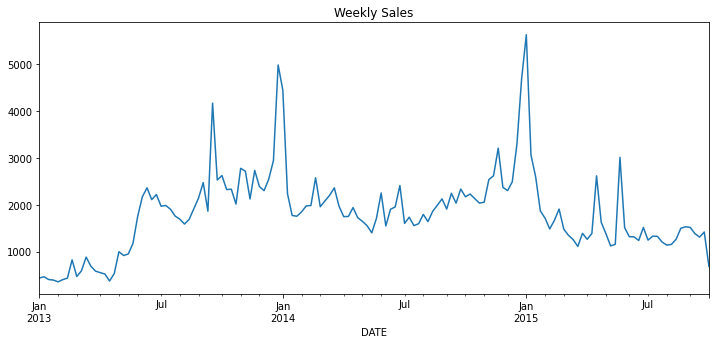

In [13]:
# Para utilizar el resample
# 1. La fecha debe estar en el índice
# 2. Debemos llamar el método resample y pasarle un regla:
#    D -> Daily
#    W -> Weekly
#    M -> Monthly
#    Y -> Yearly

df.set_index("DATE").resample("W")["SALES"].sum().plot(figsize = (12, 5), title = "Weekly Sales");

En el código anterior, hemos hecho el resample de todas las ventas.

Pero nosotros debemos tener en cuenta el item_id y el shop_id antes de hacer el resample.

Veamos como podemos combinar el groupby con resample.

In [14]:
# Implement in class

df_monthly_agg = df.set_index("DATE").groupby(["UNIQUE_ID"]).resample("M").agg(
    {
        "SALES":np.sum,
        "REVENUE":np.sum,
        "UNIQUE_DAYS_WITH_SALES":lambda dates: len(set(dates)),
        "TOTAL_TRANSACTIONS":len,
        "ITEM_PRICE":np.mean
    }
).rename(
    columns = {
        "SALES":"MONTHLY_SALES",
        "REVENUE":"MONTHLY_REVENUE",
        "ITEM_PRICE":"MONTHLY_MEAN_PRICE"
    }
).reset_index()

In [15]:
df_monthly_agg["CHECK"] = df_monthly_agg["UNIQUE_DAYS_WITH_SALES"] == df_monthly_agg["TOTAL_TRANSACTIONS"]

In [16]:
df_monthly_agg[df_monthly_agg["CHECK"] == False].sample(5)

,UNIQUE_ID,DATE,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
1728,24-5822,2013-03-31,15.0,15735.0,10,13,1049.000000,False
1609,24-3007,2013-01-31,24.0,42960.0,16,18,1790.000000,False
1546,24-2445,2013-04-30,32.0,19167.5,13,18,598.990741,False
1511,24-2308,2013-01-31,36.0,28643.5,20,25,796.593333,False
1612,24-3007,2013-04-30,12.0,22680.0,11,12,1890.000000,False


A continuación vamos a tener que comprobar si tenemos todas las fechas en nuestro dataset o no.

Dado que nuestro dataset va desde Enero'13 - Septiembre'15, son un total de 33 meses.

In [17]:
check_months = df_monthly_agg.groupby("UNIQUE_ID").size()
check_months.sample(3)

UNIQUE_ID
4-20949     29
22-20949    30
58-3734     25
dtype: int64

In [18]:
check_months[check_months != 33].shape

(173,)

Tenemos un total de 173 Series Temporales incompletas (es decir, les falta por lo menos 1 mes de registros).

El motivo de estos, es que sólo tenemos las ventas reportadas. Si un día o en un mes no se producen ventas, no tenemos estos registros en nuestro df original.

A continuación vamos a generar un dataframe con todos los registros históricos y también con el mes de Octubre'2015 (mes de predict).

In [19]:
# generamos un rango con todas las fechas incluídas en el predict (Octubre'2015)
DATE_PREDICTION = np.datetime64("2015-10-31")
date_range = pd.date_range(MIN_DATE, DATE_PREDICTION, freq = "M")
date_range

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31', '2013-11-30', '2013-12-31',
               '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30', '2015-07-31', '2015-08-31',
               '2015-09-30', '2015-10-31'],
              dtype='datetime64[ns]', freq='M')

In [20]:
# sacamos todas las combinaciones únicas que tenemos en nuestro dataframe (299 combinaciones, una por cada serie temporal)
unique_id = sorted(df_monthly_agg["UNIQUE_ID"].unique())
unique_id[:3]

['11-20949', '11-4181', '12-11365']

In [21]:
len(unique_id)

299

Generamos todas las combinaciones entre meses e unique_id.

Es decir, necesitamos sacar un [producto cartesiano](https://es.wikipedia.org/wiki/Producto_cartesiano).

In [22]:
cartesian_product = pd.MultiIndex.from_product([date_range, unique_id], names = ["DATE", "UNIQUE_ID"])
len(cartesian_product)

10166

In [23]:
# 10166 son 34 meses por todas las combinaciones de unique_id
34 * 299

10166

Cruzamos nuestro producto cartesiano con el dataframe agrupado por meses y que contiene las ventas históricas.

In [24]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()

print(full_df.shape)

full_df = pd.merge(full_df, df_monthly_agg, on = ['DATE','UNIQUE_ID'], how = 'left')

print(full_df.shape)

(10166, 2)
(10166, 8)


In [25]:
full_df.sample(5)

,DATE,UNIQUE_ID,MONTHLY_SALES,MONTHLY_REVENUE,UNIQUE_DAYS_WITH_SALES,TOTAL_TRANSACTIONS,MONTHLY_MEAN_PRICE,CHECK
6645,2014-11-30,25-17717,58.0,72697.0,23.0,23.0,1285.336957,True
5100,2014-06-30,15-5822,17.0,17518.0,12.0,12.0,1035.875000,True
1006,2013-04-30,28-5821,4.0,2396.0,4.0,4.0,599.000000,True
4665,2014-04-30,38-2808,6.0,5994.0,5.0,5.0,999.000000,True
5684,2014-08-31,12-11369,31.0,32310.0,12.0,12.0,1141.416667,True


Hemos agrupado nuestras ventas, pero hemos perdido algo de información del dataset original.

Vamos a enriquecer nuestro full_df con más información.

In [26]:
add_info = df[
    ["UNIQUE_ID", "CITY_NAME", "CITY_ID", "SHOP_NAME", "SHOP_ID", "ITEM_CATEGORY_NAME", "ITEM_CATEGORY_ID", "ITEM_NAME", "ITEM_ID"]
].drop_duplicates()

add_info.head(3)

,UNIQUE_ID,CITY_NAME,CITY_ID,SHOP_NAME,SHOP_ID,ITEM_CATEGORY_NAME,ITEM_CATEGORY_ID,ITEM_NAME,ITEM_ID
0,25-2574,Moscú,7.0,"Moscú SEC ""Atrium""",25,Música - CD de la producción local,55,Del Rey Lana Nació para morir la edición de Pa...,2574
10,25-2808,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Diablo III [PC, JEWEL, versión rusa]",2808
28,25-2308,Moscú,7.0,"Moscú SEC ""Atrium""",25,Juegos PC - Standard Edition,30,"Call of Duty: Black Ops II [PC, Jewel, versión...",2308


In [27]:
add_info.shape

(299, 9)

In [28]:
print(full_df.shape)

full_df = pd.merge(
    left = full_df,
    right = add_info,
    how = "left",
    on = "UNIQUE_ID"
)

print(full_df.shape)

(10166, 8)
(10166, 16)


<a id='impute'></a>
### Data Imputation
[Volver al índice](#index)<br>

In [29]:
full_df.drop(["CHECK"], axis = 1, inplace = True)

In [30]:
full_df.isnull().sum()

DATE                         0
UNIQUE_ID                    0
MONTHLY_SALES             1420
MONTHLY_REVENUE           1420
UNIQUE_DAYS_WITH_SALES    1420
TOTAL_TRANSACTIONS        1420
MONTHLY_MEAN_PRICE        1700
CITY_NAME                    0
CITY_ID                      0
SHOP_NAME                    0
SHOP_ID                      0
ITEM_CATEGORY_NAME           0
ITEM_CATEGORY_ID             0
ITEM_NAME                    0
ITEM_ID                      0
dtype: int64

In [31]:
full_df["MONTHLY_SALES"].fillna(0, inplace = True)
full_df["MONTHLY_REVENUE"].fillna(0, inplace = True)
full_df["UNIQUE_DAYS_WITH_SALES"].fillna(0, inplace = True)
full_df["TOTAL_TRANSACTIONS"].fillna(0, inplace = True)

In [32]:
# implementar en clase diferentes estrategias de imputación
sample_series = full_df[full_df["UNIQUE_ID"] == "7-17717"][["DATE", "UNIQUE_ID", "MONTHLY_MEAN_PRICE"]]
sample_series

,DATE,UNIQUE_ID,MONTHLY_MEAN_PRICE
296,2013-01-31,7-17717,449.000000
595,2013-02-28,7-17717,428.000000
894,2013-03-31,7-17717,619.000000
1193,2013-04-30,7-17717,390.000000
1492,2013-05-31,7-17717,599.000000
1791,2013-06-30,7-17717,NaN
2090,2013-07-31,7-17717,281.745000
2389,2013-08-31,7-17717,239.400000
2688,2013-09-30,7-17717,333.000000
2987,2013-10-31,7-17717,499.000000


In [33]:
full_df["MONTHLY_MEAN_PRICE"] = full_df.groupby("UNIQUE_ID")["MONTHLY_MEAN_PRICE"].apply(lambda series: series.backfill().ffill())

In [34]:
del df, cartesian_product, unique_id, date_range, add_info, sample_series, check_months

<a id='eda'></a>
### EDA
[Volver al índice](#index)<br>

Ahora por fin tenemos un full_df con todos los registros y con los valores imputados.

Vamos a hacer un EDA rápido para ver como son nuestras Series Temporales y coger algunas ideas para futuras variables que vamos a implementar.

Al tratarse este notebook del benchmark, vamos a explorar de manera muy superficial el dataset. En posteriores ejecuciones analizaremos el dataset en más detalle, construiremos nuevas variables y volveremos a entrenar nuestro modelo.

<a id='eda_global_sales'></a>
### --> 1. EDA: Global Sales
[Volver al índice](#index)<br>

In [35]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2)
    plot_pacf(x = y, ax = ax3)

    plt.suptitle(t = title, fontsize = 20)

In [36]:
y = full_df.set_index("DATE").resample("M")["MONTHLY_SALES"].sum()

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


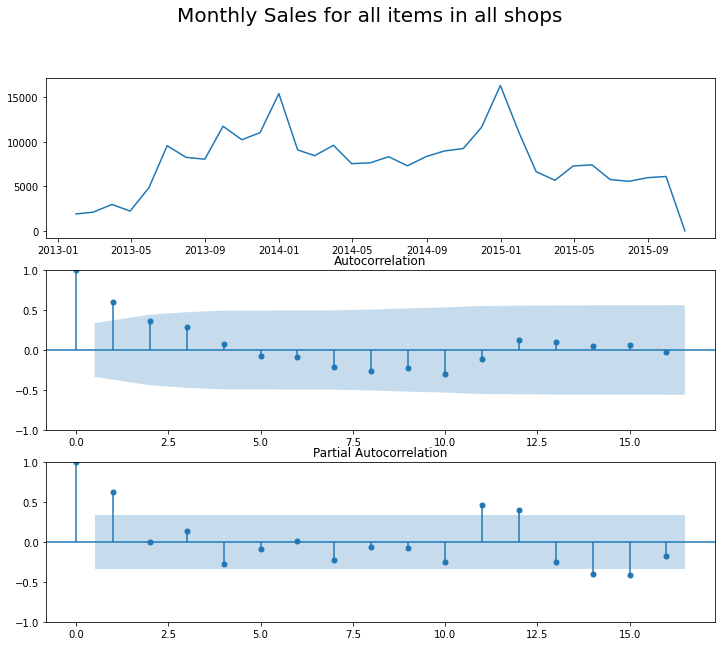

In [37]:
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

Nota importante: nos estamos ayudando del gráfico de acf y pacf, pero no vamos a entrenar un modelo ARIMA.

Para resolver el problema que se nos plantea: 299 Series Temporales diferentes tendríamos que entrenar 299 ARIMAs. En cambio, con el algoritmo de XGBoost podríamos entrenar 1 único modelo.

Ahora bien, al contrario que ARIMA (que internamente construye las variables necesarias), para XGBoost debemos ser explícitos y suministrarle todas y cada una de las variables necesarias.

Del gráfico anterior ya podemos observar que las variables de lags pueden ser muy relevantes.

IDEA para los alumnos: podéis intentar analizar algunas de las 299 Series Temporales de manera individual para ver su comportamiento.

<a id='eda_top_3_cities'></a>
### --> 2. EDA: Top 3 Cities
[Volver al índice](#index)<br>

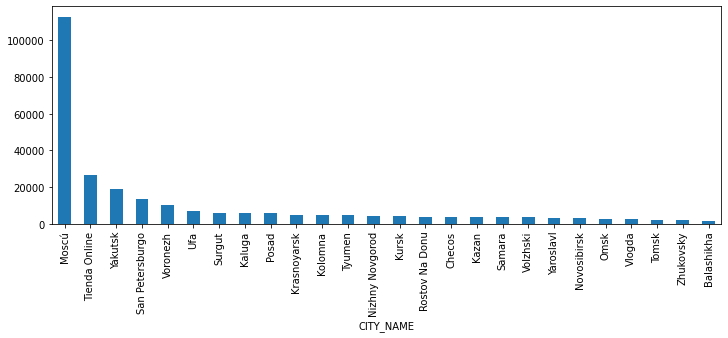

In [38]:
full_df.groupby(["CITY_NAME"])["MONTHLY_SALES"].sum().sort_values(ascending = False).plot(kind = "bar", figsize = (12, 4));

<a id='eda_top_3_categories'></a>
### --> 3. EDA: Top 3 Categories
[Volver al índice](#index)<br>

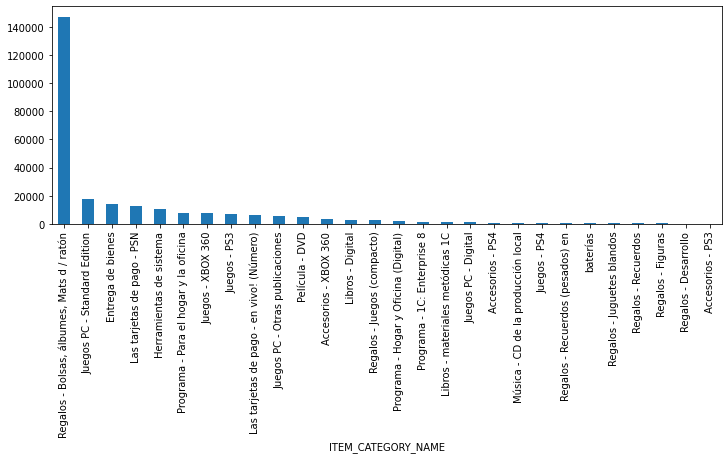

In [39]:
full_df.groupby(["ITEM_CATEGORY_NAME"])["MONTHLY_SALES"].sum().sort_values(ascending = False).plot(kind = "bar", figsize = (12, 4));

<a id='build_ts_features'></a>
### Build Time Series Features (**CORE IDEA**)
[Volver al índice](#index)<br>

Dado que vamos a tener que iterar muchas veces sobre nuestro dataset, nos interesa tener todo encapsulado en funciones para su reutilización.

Uno de los apartados clave será la generación de variables.

Como hemos visto antes, nuestro dataset contiene 299 Series Temporales.

Algunas de estas Series Temporales las podemos agrupar para sacar nueva información.

Por ejemplo, podemos construir una variables del estilo:

1. Las ventas totales por ITEM_ID (la menor granularidad posible).
2. Las ventas totales por ITEM_CATEGORY_ID y SHOP_ID (una granularidad mayor a la 1).
3. Las ventas totales por SHOP_ID (una granularidad mayor).
4. Y todas las combinaciones que queramos intermedias.

In [40]:
full_df.sample(5).T

,5778,8585,9937,6938,2601
DATE,2014-08-31 00:00:00,2015-05-31 00:00:00,2015-10-31 00:00:00,2014-12-31 00:00:00,2013-09-30 00:00:00
UNIQUE_ID,28-20608,47-5822,25-2308,25-14931,47-20949
MONTHLY_SALES,24.0,9.0,0.0,35.0,136.0
MONTHLY_REVENUE,31176.0,10341.0,0.0,24465.0,680.0
UNIQUE_DAYS_WITH_SALES,15.0,8.0,0.0,18.0,27.0
TOTAL_TRANSACTIONS,15.0,8.0,0.0,18.0,27.0
MONTHLY_MEAN_PRICE,1299.0,1149.0,299.0,699.0,5.0
CITY_NAME,Moscú,Surgut,Moscú,Moscú,Surgut
CITY_ID,7.0,15.0,7.0,7.0,15.0
SHOP_NAME,"centro comercial de Moscú ""MEGA Teply Stan"" II","Surgut SEC ""City Mall""","Moscú SEC ""Atrium""","Moscú SEC ""Atrium""","Surgut SEC ""City Mall"""


In [41]:
def build_ts_vars(full_df, gb_list, target_column, agg_func, agg_func_name, verbose = True):
    
    assert gb_list[0] == "DATE", "First element must be date"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    if verbose: print(new_name)

    gb_df_ = full_df.groupby(gb_list)[target_column].apply(agg_func).to_frame().reset_index().rename(
        columns = {
            target_column : new_name
        }
    )

    gb_df_[f"{new_name}_LAG1"] = gb_df_.groupby(gb_list[1:])[new_name].transform(
        lambda series: series.shift(1)
    )
    
    return gb_df_

In [42]:
GB_LIST_SHOP_ID = ["DATE", "SHOP_ID"]
TARGET_COLUMN = "MONTHLY_SALES"
AGG_FUNC = np.sum
AGG_FUNC_NAME = "SUM"

vars_ts_shop_id = build_ts_vars(
    full_df = full_df,
    gb_list = GB_LIST_SHOP_ID,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME
    
)

vars_ts_shop_id.sample(10)

DATE_SHOP_ID_MONTHLY_SALES_SUM


,DATE,SHOP_ID,DATE_SHOP_ID_MONTHLY_SALES_SUM,DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1
243,2013-07-31,6,199.0,258.0
622,2014-04-30,38,67.0,90.0
387,2013-10-31,45,85.0,93.0
237,2013-06-30,57,451.0,138.0
83,2013-03-31,6,47.0,48.0
288,2013-08-31,15,142.0,128.0
814,2014-09-30,24,178.0,187.0
263,2013-07-31,39,0.0,0.0
644,2014-05-31,7,98.0,139.0
1206,2015-07-31,12,380.0,395.0


<a id='join_ts_features'></a>
### Join TS Features
[Volver al índice](#index)<br>

En este apartado, hacemos el merge del full_df con las variables auxiliares.

Debemos controlar muy bien el merge, para no provocar un cartesiano.

In [43]:
rows_before_merge = full_df.shape[0]
print(f"Shape before merge is {rows_before_merge}")

full_df = pd.merge(full_df, vars_ts_shop_id, on = GB_LIST_SHOP_ID, how = "left")

rows_after_merge = full_df.shape[0]

print(f"Shape after merge is {rows_after_merge}")

assert rows_before_merge == rows_after_merge, "You have generated a cartesian product!"

Shape before merge is 10166
Shape after merge is 10166


In [44]:
full_df.to_pickle("FULL_DF_ALL_FEATURES.pkl")

<a id='train_test_split'></a>
### Train Test Split
[Volver al índice](#index)<br>

In [45]:
# explicar en clase el motivo del np.clip con el RMSE

full_df = pd.read_pickle("FULL_DF_ALL_FEATURES.pkl")
full_df["MONTHLY_SALES"] = np.clip(full_df["MONTHLY_SALES"], 0, 30)

In [46]:
COLUMNS_TO_DROP = [
    'MONTHLY_REVENUE',
    'UNIQUE_DAYS_WITH_SALES',
    'TOTAL_TRANSACTIONS',
    'MONTHLY_MEAN_PRICE',
    'CITY_NAME',
    'SHOP_NAME',
    'ITEM_CATEGORY_NAME',
    'ITEM_NAME',
    'DATE_SHOP_ID_MONTHLY_SALES_SUM'
]

full_df.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [47]:
full_df.set_index("UNIQUE_ID", inplace = True)

In [48]:
full_df.sample(5)

,DATE,MONTHLY_SALES,CITY_ID,SHOP_ID,ITEM_CATEGORY_ID,ITEM_ID,DATE_SHOP_ID_MONTHLY_SALES_SUM_LAG1
UNIQUE_ID,,,,,,,
31-16227,2013-03-31,22.0,7.0,31,65,16227,523.0
16-7856,2015-08-31,2.0,4.0,16,28,7856,82.0
57-1905,2013-12-31,9.0,23.0,57,30,1905,702.0
31-5820,2014-06-30,4.0,7.0,31,35,5820,1125.0
47-17717,2013-02-28,0.0,15.0,47,79,17717,29.0


In [49]:
train_index = sorted(list(full_df["DATE"].unique()))[:-2]

valida_index = [sorted(list(full_df["DATE"].unique()))[-2]]

test_index = [sorted(list(full_df["DATE"].unique()))[-1]]

In [50]:
X_train = full_df[full_df["DATE"].isin(train_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_train = full_df[full_df["DATE"].isin(train_index)]['MONTHLY_SALES']

X_valida = full_df[full_df["DATE"].isin(valida_index)].drop(['MONTHLY_SALES', "DATE"], axis=1)
Y_valida = full_df[full_df["DATE"].isin(valida_index)]['MONTHLY_SALES']

X_test = full_df[full_df["DATE"].isin(test_index)].drop(['MONTHLY_SALES', "DATE"], axis = 1)
Y_test = full_df[full_df["DATE"].isin(test_index)]['MONTHLY_SALES']

<a id='model_train'></a>
### Model Train
[Volver al índice](#index)<br>

Entrenamos nuestro modelo de Machine Learning (benchmark).

In [51]:
model = xgb.XGBRegressor(eval_metric = "rmse", early_stopping_rounds = 10, seed = 175)

model_name = str(model).split("(")[0]

day = str(datetime.now()).split()[0].replace("-", "_")
hour = str(datetime.now()).split()[1].replace(":", "_").split(".")[0]
t = str(day) + "_" + str(hour)

model.fit(X_train, Y_train, 
    eval_set = [(X_train, Y_train), (X_valida, Y_valida)], 
    verbose = True)

[0]	validation_0-rmse:12.23904	validation_1-rmse:10.68234
[1]	validation_0-rmse:10.34501	validation_1-rmse:8.80812
[2]	validation_0-rmse:9.14312	validation_1-rmse:7.71132
[3]	validation_0-rmse:8.47588	validation_1-rmse:7.13493
[4]	validation_0-rmse:8.08249	validation_1-rmse:6.75268
[5]	validation_0-rmse:7.86980	validation_1-rmse:6.58971
[6]	validation_0-rmse:7.69938	validation_1-rmse:6.50562
[7]	validation_0-rmse:7.59184	validation_1-rmse:6.31958
[8]	validation_0-rmse:7.50147	validation_1-rmse:6.31641
[9]	validation_0-rmse:7.44398	validation_1-rmse:6.32311
[10]	validation_0-rmse:7.35337	validation_1-rmse:6.25201
[11]	validation_0-rmse:7.30187	validation_1-rmse:6.22781
[12]	validation_0-rmse:7.24895	validation_1-rmse:6.22319
[13]	validation_0-rmse:7.20696	validation_1-rmse:6.23704
[14]	validation_0-rmse:7.14459	validation_1-rmse:6.27415
[15]	validation_0-rmse:7.11341	validation_1-rmse:6.25239
[16]	validation_0-rmse:7.05256	validation_1-rmse:6.19421
[17]	validation_0-rmse:7.01547	validat

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=175,
             reg_alpha=0, reg_lambda=1, ...)

In [52]:
pickle.dump(model, open("{}_{}.dat".format(model_name, t), "wb"))
print("{}_{}.dat".format(model_name, t))

XGBRegressor_2022_12_25_18_21_25.dat


<a id='model_evaluation'></a>
### Model Evaluation (**CORE IDEA**)
[Volver al índice](#index)<br>

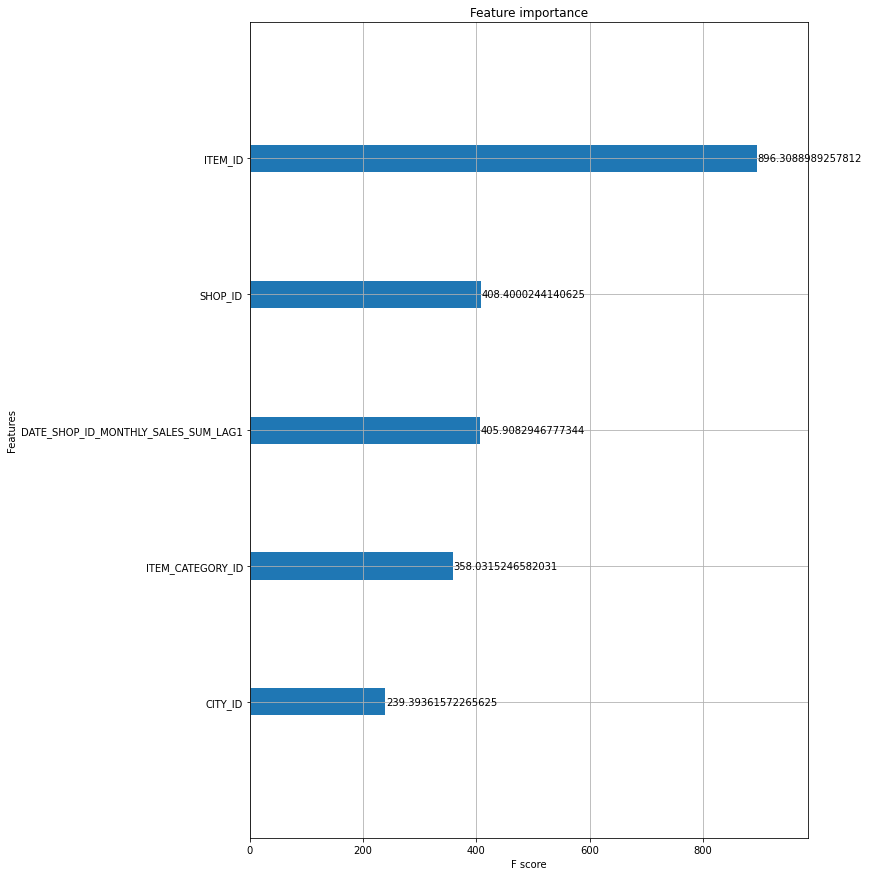

In [53]:
importance = model.get_booster().get_score(importance_type = "gain")
importance = {k: v for k, v in sorted(importance.items(), key = lambda item: item[1])}

fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

<a id='prediction'></a>
### Prediction
[Volver al índice](#index)<br>

En este apartado vamos a utilizar el modelo entrenado para hacer una predicción y posteriormente enviar el submit a Kaggle.

In [54]:
last_trained_model = pickle.load(open("{}_{}.dat".format(model_name, t), "rb"))

In [55]:
Y_valida_pred = model.predict(X_valida)

rmse_valida = np.sqrt(mean_squared_error(Y_valida, Y_valida_pred))
rmse_valida

5.993250763638941

In [56]:
if "SALES_PREDICTED" in X_test.columns:
    X_test.drop("SALES_PREDICTED", axis = 1, inplace = True)
    
Y_test_predict = model.predict(X_test)
X_test["SALES_PREDICTED"] = np.clip(Y_test_predict, 0, 30)

In [57]:
X_test.reset_index(inplace = True)

In [58]:
(
    X_test[["UNIQUE_ID", "SALES_PREDICTED"]]
    .rename(columns = {"UNIQUE_ID":"unique_id", "SALES_PREDICTED":"sales"})
    .to_csv("submission.csv", index = False)
)

<a id='conclusion'></a>
### Conclusión
[Volver al índice](#index)<br>

En este notebook hemos explorado la importancia en Machine Learning de utilizar un modelo benchmark cuando nos enfrentamos por primera vez a un nuevo dataset.

Establecer el benchmark nos ayuda a entender cual es el punto de partida.

Al entrenar un modelo, tenemos ya un notebook funcional que nos permite entrar en la siguiente loop:

1. Hacer un poco más de EDA.
2. Construir nuevas variables.
3. Probar estas variables en el modelo.
4. Guardar el score para ver la mejora o no (Kaggle Submit).
5. Volver al punto 1.

A continuación dejamos algunas ideas que los alumnos pueden implementar para mejorar el benchmark:

1. Probad otras combinaciones de variables.
2. Darle más profundidad a los lags/shifts.
3. Implementar medias móviles (ojo variables autoexplicativas).
4. Utilizar otras columnas en vez de MONTHLY_SALES para construir las variables.
5. Añadir variables externas (relación rublo/dólar, festivos locales etc).
6. Probar otros algoritmos.
7. Tunnear los hiperparametros del modelo.

### Happy Kaggling :)

<a id='referencias'></a>
### Referencias y lecturas recomendables
[Volver al índice](#index)<br>

A continuación dejamos algunos links útiles para profundizar en algunos de los conceptos que hemos visto en el notebook:

[The importance of Benchmarking](https://blog.bigml.com/2020/03/20/machine-learning-benchmarking-youre-doing-it-wrong/)

[Tree Based Models and Extrapolation (MUY RECOMENDABLE)](https://shanminlin.medium.com/how-to-help-tree-based-models-extrapolate-7954287b1219)

[XGBoost](https://xgboost.readthedocs.io/en/stable/)